# Data Scientist Salary Data Collection and Analysis

## Setup

<u> dependencies </u>  
python version 3.9.12  
selenium version 4.9.0  
beautifulsoup4 version 4.11.1  
numpy version 1.21.5  
pandas version 1.4.2  
regex version 2022.3.15

- might need to log into glassdoor and submit a review to gain access
- selenium package must be installed and chrome web driver configured

## Data Collection

In [1]:
# selenium and beautiful soup packages are used for web scraping
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from bs4 import BeautifulSoup

# common packages
import numpy as np
import pandas as pd
import re

In [2]:
# initialize an empty dataframe that will be used to store the data collected from glassdoor salary postings
salaryDataframe = pd.DataFrame(
    columns = ["companyName", "companyRating", "position", "sampleSize", "openJobs", "salaryLow", "salaryMid", "salaryHigh"]
)

The following code chunk contains a program that will automatically collect data from thousands of glassdoor salary postings for data scientist positions. Each salary posting is the aggregate of one or more submissions made by users who provided salary information to glassdoor.

*Note: this will take some time to run. It may take up to one hour or more.*

Before running the program, there are couple of things to check.
- Set the "maxPageNum" variable accordingly. It should be set to the number of glassdoor search results divided by 20 plus 1. For example, in this case, the number of search results is 9,360. So 9,360 / 20 = 468 and 468 + 1 = 469.
- Set the "chromeDriverPath" variable accordingly. It should be set to the file path to where the chromedriver.exe file is located on the machine. This would be determined during chromedriver configuration.

In [3]:
# set the maxPageNum variable
maxPageNum = 469

In [4]:
# set the chromeDriverPath variable
chromeDriverPath = "C:\Program Files (x86)\chromedriver.exe"

In [5]:
# iterate through the glassdoor salary pages and collect the data
for pageNum in list(range(1, maxPageNum, 1)):

    # generate the link for the page dynamically
    link = "https://www.glassdoor.com/Salaries/data-scientist-salary-SRCH_KO0,14_IP" + str(pageNum) + ".htm"
    
    # configure the chrome web driver and start up chrome instance
    service = Service(chromeDriverPath)
    options = webdriver.ChromeOptions()
    driver = webdriver.Chrome(service=service, options=options)

    # navigate to the web page in the selenium chrome window
    driver.get(link)

    # capture the raw html code for the web page
    html = driver.page_source

    # initialize a bs object with the html code
    soup = BeautifulSoup(html, "html.parser")

    # filter on the employerStats chunk of html code
    # this tag contains a portion of the targeted information
    soup_employerStats = soup.find_all("div", class_="employerStats")

    # filter on the rangeBar chunk of html code
    # this tag contains another portion of targeted information
    soup_rangeBar = soup.find_all("div", class_="col-12 col-lg-6 order-1 order-md-2 order-lg-1 pt-xl pt-lg-0")

    # extract company names
    companies = []
    for soup in soup_employerStats:
        company = soup.find("a", class_="css-1ikln7a el6ke052")
        companies.append(company.text)

    # extract company ratings
    ratings = []
    for soup in soup_employerStats:
        rating = soup.find("span", class_="css-h9sogr m-0 css-60s9ld el6ke050")
        
        # ratings do not exist for every posting so must handle cases when there is no rating
        try:
            ratings.append(rating.text)
        except AttributeError:
            ratings.append("-1") # temp value to indicate there is no rating

    # parse string and convert to float data type
    ratings = [float(re.sub(",", "", rating)) for rating in ratings] # remove commas and convert to float

    # extract position names
    positions = []
    for soup in soup_employerStats:
        position = soup.find("span", class_="d-flex align-items-middle css-1in2cw4 el6ke050")
        positions.append(position.text)

    # extract sample sizes
    sampleSizes = []
    for soup in soup_employerStats:
        sampleSize = soup.find("a", class_="m-0 d-flex css-259095 e1aj7ssy6")
        sampleSizes.append(sampleSize.text)

    # parse string and convert to integer data type
    sampleSizes = [re.sub("See\s", "", sampleSize) for sampleSize in sampleSizes] # remove text
    sampleSizes = [re.sub("\ssalaries\sfrom\sall\slocations", "", sampleSize) for sampleSize in sampleSizes] # remove text
    sampleSizes = [int(re.sub(",", "", sampleSize)) for sampleSize in sampleSizes] # remove commas and convert to int

    # extract open job counts
    openJobCounts = []
    for soup in soup_employerStats:
        openJobCount = soup.find("a", class_="css-259095 e1aj7ssy6")

        # open job counts do not exist for every posting so must handle cases when there is no open job count
        try:
            openJobCounts.append(openJobCount.text)
        except AttributeError:
            openJobCounts.append("-1") # temp value to indicate there is no open job count

    # parse string and convert to integer data type
    openJobCounts = [re.sub("\sopen\sjobs", "", openJobCount) for openJobCount in openJobCounts] # remove text
    openJobCounts = [int(re.sub(",", "", openJobCount)) for openJobCount in openJobCounts] # remove commas and convert to int

    # extract salary ranges
    salaryRanges = []
    for salaryRange in soup_rangeBar:
        salaryRanges.append(re.findall("\$[0-9,K]*", salaryRange.text))

    # parse the salary lows
    salaryLows = []
    for salaryRange in salaryRanges:
        salaryLow = re.sub("\$", "", salaryRange[1]) # remove dollar signs
        salaryLow = re.sub(",", "", salaryLow) # remove commas
        salaryLow = re.sub("K", "000", salaryLow) # replace "K" with three zeros
        salaryLows.append(int(salaryLow)) # convert to int and append to list

    # parse the salary mids
    salaryMids = []
    for salaryRange in salaryRanges:
        salaryMid = re.sub("\$", "", salaryRange[0]) # remove dollar signs
        salaryMid = re.sub(",", "", salaryMid) # remove commas
        salaryMid = re.sub("K", "000", salaryMid) # replace "K" with three zeros
        salaryMids.append(int(salaryMid)) # convert to int and append to list

    # parse the salary highs
    salaryHighs = []
    for salaryRange in salaryRanges:
        salaryHigh = re.sub("\$", "", salaryRange[2]) # remove dollar signs
        salaryHigh = re.sub(",", "", salaryHigh) # remove commas
        salaryHigh = re.sub("K", "000", salaryHigh) # replace "K" with three zeros
        salaryHighs.append(int(salaryHigh)) # convert to int and append to list

    # close out the driver
    driver.quit()
    
    # put together the data in a pandas dataframe
    df = pd.DataFrame(
        list(zip(companies, ratings, positions, sampleSizes, openJobCounts, salaryLows, salaryMids, salaryHighs)),
        columns =["companyName", "companyRating", "position", "sampleSize", "openJobs", "salaryLow", "salaryMid", "salaryHigh"]
    )
    
    # append the data from this instance to the cumulative dataframe
    salaryDataframe = pd.concat([salaryDataframe, df], ignore_index = True)

In [6]:
salaryDataframe

,companyName,companyRating,position,sampleSize,openJobs,salaryLow,salaryMid,salaryHigh
0,Meta,3.9,Data Scientist,1499,722,200000,247842,313000
1,Ascendum Solutions,4.4,Data Scientist,602,-1,105000,129784,162000
2,IBM,3.9,Data Scientist,585,5764,126000,155882,195000
3,Google,4.4,Data Scientist,538,1598,188000,235591,301000
4,Amazon,3.7,Data Scientist,519,12652,164000,203114,257000
...,...,...,...,...,...,...,...,...
9197,All American Healthcare,3.1,Data Scientist,1,13433,96000,119336,150000
9198,Designer Brands,3.7,Data Scientist,1,42,108000,131418,161000
9199,Ascent (UK),4.5,Data Scientist,1,-1,107000,133588,168000
9200,Mr. John Portable Toilet Rental,4.4,Data Scientist,1,4,10000,11835,15000


**companyName**: the name of the company listed in the salary posting  
**companyRating**: represents the average rating among the submissions in the sample  
**position**: the name of the position listed in the salary posting  
**sampleSize**: the number of submissions that comprise the salary posting data  
**openJobs**: current number of open jobs at the company  
**salaryLow**: low point of the range bar in the distribution of salaries  
**salaryMid**: mid point of the range bar in the distribution of salaries  
**salaryHigh**: high point of the range bar in the distribution of salaries

## Data Cleansing

For salary postings where there was no company rating available, a temporary value of -1 was put in place in the rating column. Now, these -1 values will be replaced with a value of NA to indicate that there was no data available.

In [7]:
# convert the company rating values of -1 to NA
salaryDataframe.companyRating = salaryDataframe.companyRating.replace(-1, None)

In [8]:
# inspect the distribution of company rating values
salaryDataframe.companyRating.value_counts(dropna = False).sort_index(ascending=True)

1.0     29
1.2      2
1.4      1
1.5      2
1.6      6
1.7      5
1.8      1
1.9      3
2.0     24
2.1     10
2.2     17
2.3     16
2.4     36
2.5     32
2.6     47
2.7     65
2.8     92
2.9    149
3.0    206
3.1    231
3.2    258
3.3    302
3.4    432
3.5    469
3.6    580
3.7    644
3.8    715
3.9    754
4.0    779
4.1    649
4.2    573
4.3    399
4.4    306
4.5    243
4.6    159
4.7    116
4.8    103
4.9     45
5.0    371
NaN    331
Name: companyRating, dtype: int64

For salary postings where there was no open job count available, a temporary value of -1 was put in place in the open job count column. Now, these -1 values will be replaced with a value of NA to indicate that there was no data available.

In [9]:
# convert the open job count values of -1 to NA
salaryDataframe.openJobs = salaryDataframe.openJobs.replace(-1, None)

In [10]:
# inspect the distribution of open job count values
salaryDataframe.openJobs.value_counts(dropna = False).sort_index(ascending=True)

2.0          243
3.0          221
4.0          182
5.0          148
6.0          130
            ... 
51410.0        1
84157.0        1
100459.0       1
108467.0       1
NaN         3632
Name: openJobs, Length: 1184, dtype: int64

Even though the search in glass door was for "Data Scientist" positions, not all of the positions returned are exactly "Data Scientist". Next, this will be further examined.

In [11]:
# look at the different names of positions
salaryDataframe.position.value_counts(dropna = False)

Data Scientist         7854
Data Science           1233
Data Scientist I        101
Cientista De Dados        6
Data Scientist/           3
Científico De Datos       2
ET Data Scientist         1
Data Scientist,           1
 Data Scientist           1
Name: position, dtype: int64

As seen above, the majority of positions are "Data Scientist", but there are some that are not. Should the records with other position names be kept in the dataset or removed from the dataset?

There are a small handfull of odd position names. These will simply be removed from the dataset, leaving only the "Data Science" and "Data Scientist I" positions in question.

In [12]:
# remove all positions that are not "Data Scientist", "Data Science", and "Data Scientist I"
salaryDataframe = salaryDataframe[salaryDataframe.position.isin(["Data Scientist", "Data Science", "Data Scientist I"])]
salaryDataframe

,companyName,companyRating,position,sampleSize,openJobs,salaryLow,salaryMid,salaryHigh
0,Meta,3.9,Data Scientist,1499,722,200000,247842,313000
1,Ascendum Solutions,4.4,Data Scientist,602,None,105000,129784,162000
2,IBM,3.9,Data Scientist,585,5764,126000,155882,195000
3,Google,4.4,Data Scientist,538,1598,188000,235591,301000
4,Amazon,3.7,Data Scientist,519,12652,164000,203114,257000
...,...,...,...,...,...,...,...,...
9197,All American Healthcare,3.1,Data Scientist,1,13433,96000,119336,150000
9198,Designer Brands,3.7,Data Scientist,1,42,108000,131418,161000
9199,Ascent (UK),4.5,Data Scientist,1,None,107000,133588,168000
9200,Mr. John Portable Toilet Rental,4.4,Data Scientist,1,4,10000,11835,15000


How many records with the position of "Data Science" have a record for the same company with "Data Scientist" as the position?

In [13]:
companies_ds = list(salaryDataframe[salaryDataframe.position == "Data Science"].companyName)
print(len(companies_ds))
print(companies_ds)

1233
['Meta', 'Microsoft', 'Amazon', 'Adobe', 'Google', 'Apple', 'Johnson & Johnson', 'IBM', 'Verizon', 'Travelers', 'Nielsen', 'Cisco Systems', 'Capital One', 'eBay', 'ADP', 'Autodesk', 'Oracle', 'MITRE', 'SAP', 'LinkedIn', 'Walt Disney Company', 'Intel Corporation', 'Accenture', '84.51°', 'The Hartford', 'PayPal', '3M', 'Liberty Mutual Insurance', 'Fidelity Investments', 'Spotify', 'AT&T', 'Walmart', 'John Deere', 'Dell Technologies', 'Boeing', 'Truist', 'AARP', 'Chegg', 'Ford Motor Company', 'Tesla', 'Bayer', 'NASA', 'American Express', 'Intuit', 'Recursion Pharmaceuticals', 'UKG', 'UnitedHealth Group', 'Nationwide', 'JPMorgan Chase & Co', 'Red Hat', 'Salesforce', 'Booz Allen Hamilton', 'Pfizer', 'Wells Fargo', 'Uber', 'NCR', 'UPS', 'Verisk', 'NBCUniversal', 'Nokia', 'Merck', 'MilliporeSigma', 'Veritas Technologies', 'Sears', 'Twitter', 'Expedia Group', 'NIKE', 'CCC Intelligent Solutions', 'Genentech', 'CVS Health', 'Pinsight Media', 'AbbVie', 'Principal Financial Group', 'Chevron',

In [14]:
salaryDataframe[(salaryDataframe.companyName.isin(companies_ds)) & (salaryDataframe.position == "Data Scientist")]

,companyName,companyRating,position,sampleSize,openJobs,salaryLow,salaryMid,salaryHigh
0,Meta,3.9,Data Scientist,1499,722,200000,247842,313000
2,IBM,3.9,Data Scientist,585,5764,126000,155882,195000
3,Google,4.4,Data Scientist,538,1598,188000,235591,301000
4,Amazon,3.7,Data Scientist,519,12652,164000,203114,257000
5,"Quora, Inc.",4.4,Data Scientist,514,16,133000,164928,208000
...,...,...,...,...,...,...,...,...
9117,Rotella Capital Management,2.8,Data Scientist,1,None,66,82,104
9173,Foxconn Industrial Internet,3.4,Data Scientist,1,34,109000,137419,174000
9179,Lark,4.2,Data Scientist,1,None,100000,123849,155000
9183,Lark,4.2,Data Scientist,1,None,100000,123849,155000


Out of the 1,233 records that have the position of "Data Science", 780 of those records have a record for the same company with "Data Scientist" as the position.

This means that most of the records with the position of "Data Science" are duplicates, so all 1,233 of these records will be removed from the dataset.

In [15]:
# remove the rows with position of "Data Science"
salaryDataframe = salaryDataframe[salaryDataframe.position != "Data Science"]
salaryDataframe

,companyName,companyRating,position,sampleSize,openJobs,salaryLow,salaryMid,salaryHigh
0,Meta,3.9,Data Scientist,1499,722,200000,247842,313000
1,Ascendum Solutions,4.4,Data Scientist,602,None,105000,129784,162000
2,IBM,3.9,Data Scientist,585,5764,126000,155882,195000
3,Google,4.4,Data Scientist,538,1598,188000,235591,301000
4,Amazon,3.7,Data Scientist,519,12652,164000,203114,257000
...,...,...,...,...,...,...,...,...
9197,All American Healthcare,3.1,Data Scientist,1,13433,96000,119336,150000
9198,Designer Brands,3.7,Data Scientist,1,42,108000,131418,161000
9199,Ascent (UK),4.5,Data Scientist,1,None,107000,133588,168000
9200,Mr. John Portable Toilet Rental,4.4,Data Scientist,1,4,10000,11835,15000


Let's perform the same check on the positions of "Data Scientist I"

In [16]:
companies_ds1 = list(salaryDataframe[salaryDataframe.position == "Data Scientist I"].companyName)
print(len(companies_ds1))
print(companies_ds1)

101
['Amazon', 'Insurance Services Office', 'Centene', 'Elevate Credit', 'Grubhub', 'NASA Jet Propulsion Laboratory', 'Pacific Northwest National Laboratory', 'UnitedHealth Group', 'Verisk', 'Uber', 'Expedia Group', 'Cleveland Clinic', 'Schneider', 'Wolters Kluwer R&D U.S', 'Truist', 'USAA', 'American Family Insurance', 'NanoString', "Children's Hospital of Philadelphia", 'E Source', 'Cotiviti', 'American Home Shield', 'McKinsey & Company', 'Oscar Health', 'GEICO', 'Unum', 'Ingram Micro', 'L3Harris', 'Stride Funding', 'Redstone Federal Credit Union', 'The Trade Desk', 'J.B. Hunt Transport', 'Chickasaw Nation', 'Distilled Technology', 'Distilled Technology', 'Northeast Information Discovery', 'Optum', 'Knowesis', 'Progressive Leasing', 'Savvysherpa', 'Limeade', 'A-Alpha Bio', 'Brinks Home', 'Medallia', 'Warner Bros. Discovery', 'Liberty Mutual Insurance', 'Adtalem Global Education', 'RiskGenius', 'Zulily', 'Transamerica', 'Chewy', 'AbbVie', 'bioMérieux', 'Twitter', 'FloatMe', 'Massachus

In [17]:
salaryDataframe[(salaryDataframe.companyName.isin(companies_ds1)) & (salaryDataframe.position == "Data Scientist")]

,companyName,companyRating,position,sampleSize,openJobs,salaryLow,salaryMid,salaryHigh
4,Amazon,3.7,Data Scientist,519,12652,164000,203114,257000
7,Expedia Group,4.1,Data Scientist,426,170,155000,187702,231000
15,Uber,3.9,Data Scientist,201,15830,159000,199401,255000
22,PayPal,4.0,Data Scientist,130,1061,156000,189834,235000
36,Verisk,3.8,Data Scientist,82,176,111000,132240,160000
...,...,...,...,...,...,...,...,...
5901,National Ecological Observatory Network,3.2,Data Scientist,1,None,89000,108674,134000
7059,Redstone Federal Credit Union,4.0,Data Scientist,1,11,104000,126357,156000
7414,Adtalem Global Education,2.9,Data Scientist,1,31,95000,117256,146000
7907,Dana-Farber Cancer Institute,4.0,Data Scientist,1,377,97000,120811,152000


Out of the 101 records that have the position of "Data Scientist I", 79 of those records have a record for the same company with "Data Scientist" as the position.

Thus, since most of the records with the position of "Data Scientist I" are duplicates, all 101 of these records will be removed from the dataset.

In [18]:
# remove the rows with position of "Data Scientist I"
salaryDataframe = salaryDataframe[salaryDataframe.position != "Data Scientist I"]
salaryDataframe

,companyName,companyRating,position,sampleSize,openJobs,salaryLow,salaryMid,salaryHigh
0,Meta,3.9,Data Scientist,1499,722,200000,247842,313000
1,Ascendum Solutions,4.4,Data Scientist,602,None,105000,129784,162000
2,IBM,3.9,Data Scientist,585,5764,126000,155882,195000
3,Google,4.4,Data Scientist,538,1598,188000,235591,301000
4,Amazon,3.7,Data Scientist,519,12652,164000,203114,257000
...,...,...,...,...,...,...,...,...
9196,Carbon Health,3.3,Data Scientist,1,314,113000,141138,178000
9197,All American Healthcare,3.1,Data Scientist,1,13433,96000,119336,150000
9198,Designer Brands,3.7,Data Scientist,1,42,108000,131418,161000
9199,Ascent (UK),4.5,Data Scientist,1,None,107000,133588,168000


Next, let's take a look at the salary numbers.

<AxesSubplot:>

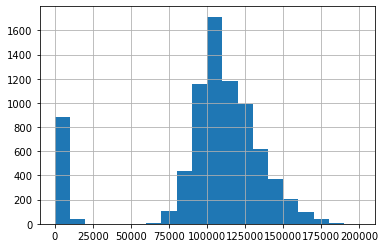

In [19]:
salaryDataframe.salaryLow.hist(bins = 20)

In looking at the histogram of the salary lows, we see that it is pretty normally distributed but there is an odd portion of salaries that are very low compared to the rest.

Some of these are values that are listed as an hourly wage value rather than an annual salary value. So we need to convert these from hourly to annual.

The formula for converting an hourly wage to an annual salary will be Annual Salary = Hourly Wage × Hours Worked per Week × Weeks Worked per Year where hours worked per week = 40 and weeks worked per year = 52.

Others are values that are imbetween being an hourly wage or an annual salary. For example, 10,000 is way too low for an annual salary but way too high for an hourly wage. These values will be removed from the dataset.

the cut off point of acceptable hourly wage values will be based on the max value in the distribution. For example, if the max annual salary is 175,000, that would equate to roughly 84/hour.

In [20]:
# determine the max annual salary number in the salary low distribution
max(salaryDataframe.salaryLow)

200000

In [21]:
# determine the hourly wage cut off point based on the max annual salary number
200000 / 52 / 40

96.15384615384616

In [22]:
# determine the min annual salary number in the salary low distribution
salaryDataframe[(salaryDataframe.salaryLow >= 0) & (salaryDataframe.salaryLow <= 70000)].salaryLow.value_counts().sort_index(ascending = False)

70000    1
69000    1
67000    1
15000    1
14000    2
        ..
38       7
37       6
36       1
35       5
34       2
Name: salaryLow, Length: 61, dtype: int64

For the salary lows, we have calculated that anything less than or equal to 96.15 is an hourly wage that should be converted to an annual salary, and anything greater than 96.15 and less than or equal to 15,000 is an inconclusive value and should be removed from the dataset.

In [23]:
# remove salary lows that are greater than 96.15 and less than or equal to 15,000
salaryDataframe = salaryDataframe[(salaryDataframe.salaryLow <= 96.15) | (salaryDataframe.salaryLow > 15000)]
salaryDataframe

,companyName,companyRating,position,sampleSize,openJobs,salaryLow,salaryMid,salaryHigh
0,Meta,3.9,Data Scientist,1499,722,200000,247842,313000
1,Ascendum Solutions,4.4,Data Scientist,602,None,105000,129784,162000
2,IBM,3.9,Data Scientist,585,5764,126000,155882,195000
3,Google,4.4,Data Scientist,538,1598,188000,235591,301000
4,Amazon,3.7,Data Scientist,519,12652,164000,203114,257000
...,...,...,...,...,...,...,...,...
9195,Global Fishing Watch,5.0,Data Scientist,1,None,91000,113696,143000
9196,Carbon Health,3.3,Data Scientist,1,314,113000,141138,178000
9197,All American Healthcare,3.1,Data Scientist,1,13433,96000,119336,150000
9198,Designer Brands,3.7,Data Scientist,1,42,108000,131418,161000


C:\Users\Tyler\AppData\Local\Temp\ipykernel_24444\986096319.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salaryDataframe["salaryLow"] = np.where(salaryDataframe["salaryLow"] <= 96.15, salaryDataframe["salaryLow"] * 40 * 52, salaryDataframe["salaryLow"])


<AxesSubplot:>

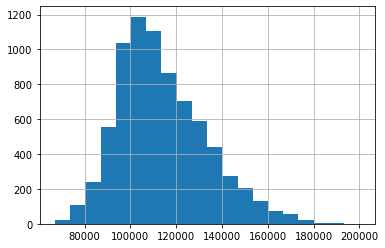

In [24]:
# convert the salary lows hourly wages to annual salary
salaryDataframe["salaryLow"] = np.where(salaryDataframe["salaryLow"] <= 96.15, salaryDataframe["salaryLow"] * 40 * 52, salaryDataframe["salaryLow"])
salaryDataframe.salaryLow.hist(bins = 20)

We can see that the distribution of the salary lows is now cleaned up.

We will perform the same logic on the salary mids and the salary highs.

<AxesSubplot:>

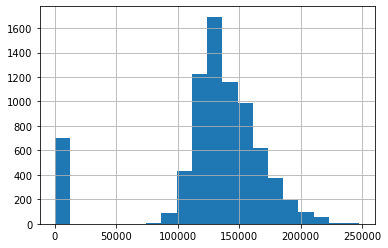

In [25]:
salaryDataframe.salaryMid.hist(bins = 20)

In [26]:
# determine the max annual salary number in the salary mid distribution
max(salaryDataframe.salaryMid)

247842

In [27]:
# determine the hourly wage cut off point based on the max annual salary number
247842 / 52 / 40

119.15480769230768

In [28]:
# determine the min annual salary number in the salary mid distribution
salaryDataframe[(salaryDataframe.salaryMid >= 0) & (salaryDataframe.salaryMid <= 86000)].salaryMid.value_counts().sort_index(ascending = False)

85781     1
84701     1
106       2
98        2
97        1
96        2
93        2
92        3
91        3
89        5
88        3
87        4
86        2
85        6
84       10
83       11
82        7
81        3
80        8
79       11
78        8
77        8
76        8
75        5
74       16
73       18
72       17
71       20
70       17
69       19
68       18
67       20
66       19
65       14
64       25
63       19
62       36
61       40
60       37
59       52
58       22
57       23
56       15
55       19
54       20
53       17
52       23
51       13
50       12
49       10
48        3
47        9
46        3
45        2
44        4
43        1
42        2
Name: salaryMid, dtype: int64

For the salary mids, we have calculated that anything less than or equal to 119.15 is an hourly wage that should be converted to an annual salary. We do not have any inconclusive values to handle since those records have already been removed during the salary lows cleanup effort.

C:\Users\Tyler\AppData\Local\Temp\ipykernel_24444\25759452.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salaryDataframe["salaryMid"] = np.where(salaryDataframe["salaryMid"] <= 119.15, salaryDataframe["salaryMid"] * 40 * 52, salaryDataframe["salaryMid"])


<AxesSubplot:>

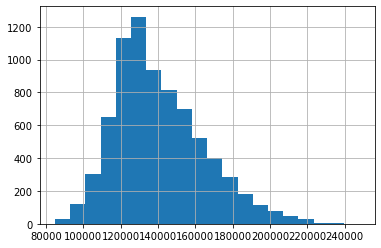

In [29]:
# convert the salary mids hourly wages to annual salary
salaryDataframe["salaryMid"] = np.where(salaryDataframe["salaryMid"] <= 119.15, salaryDataframe["salaryMid"] * 40 * 52, salaryDataframe["salaryMid"])
salaryDataframe.salaryMid.hist(bins = 20)

<AxesSubplot:>

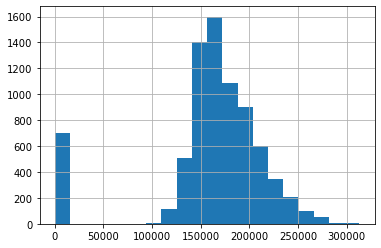

In [30]:
salaryDataframe.salaryHigh.hist(bins = 20)

In [31]:
# determine the max annual salary number in the salary high distribution
max(salaryDataframe.salaryHigh)

313000

In [32]:
# determine the hourly wage cut off point based on the max annual salary number
313000 / 52 / 40

150.48076923076923

In [33]:
# determine the min annual salary number in the salary high distribution
salaryDataframe[(salaryDataframe.salaryHigh >= 0) & (salaryDataframe.salaryHigh <= 110000)].salaryHigh.value_counts().sort_index(ascending = False)

109000    2
108000    2
107000    1
106000    2
136       1
         ..
57        3
56        3
55        3
54        2
53        1
Name: salaryHigh, Length: 73, dtype: int64

For the salary highs, we have calculated that anything less than or equal to 150.48 is an hourly wage that should be converted to an annual salary. We do not have any inconclusive values to handle since those records have already been removed during the salary lows cleanup effort.

C:\Users\Tyler\AppData\Local\Temp\ipykernel_24444\1995057215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salaryDataframe["salaryHigh"] = np.where(salaryDataframe["salaryHigh"] <= 150.48, salaryDataframe["salaryHigh"] * 40 * 52, salaryDataframe["salaryHigh"])


<AxesSubplot:>

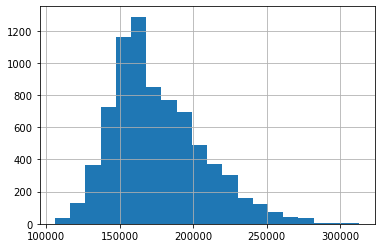

In [34]:
# convert the salary highs hourly wages to annual salary
salaryDataframe["salaryHigh"] = np.where(salaryDataframe["salaryHigh"] <= 150.48, salaryDataframe["salaryHigh"] * 40 * 52, salaryDataframe["salaryHigh"])
salaryDataframe.salaryHigh.hist(bins = 20)

With the distributions of salary data looking reasonable, we can be confident that the data is trustworthy and the numbers make sense.

As a final data cleansing task, we need to make sure that we do not have duplicate records. We should only have one record per company. For example, we should not have 2 records for Amazon Data Scientist. This could skew the results.

In [35]:
# check for duplicate companies in the dataset
print(len(salaryDataframe))
print(len(set(salaryDataframe.companyName)))

7630
7450


Out of the 7,742 records in the dataset, there are 7,556 unique companies, which indicates that there are some duplicates. Let's take a closer look at these duplicates and see how they might be affecting the data.

In [36]:
salaryDataframe.companyName.value_counts()

United Solutions      3
XYZ                   3
John Deere            3
Verizon               3
Northrop Grumman      3
                     ..
LSC Communications    1
Qorvo                 1
Tenet Healthcare      1
Fortive               1
Ascent (UK)           1
Name: companyName, Length: 7450, dtype: int64

In [37]:
salaryDataframe[salaryDataframe.companyName == "United Solutions"]

,companyName,companyRating,position,sampleSize,openJobs,salaryLow,salaryMid,salaryHigh
1567,United Solutions,4.2,Data Scientist,3,8,91000,110738,136000
2519,United Solutions,1.6,Data Scientist,2,None,101000,123653,153000
4922,United Solutions,3.6,Data Scientist,1,None,94000,114632,141000


In [38]:
salaryDataframe[salaryDataframe.companyName == "Northrop Grumman"]

,companyName,companyRating,position,sampleSize,openJobs,salaryLow,salaryMid,salaryHigh
97,Northrop Grumman,4.0,Data Scientist,39,3236,101000,120911,146000
2692,Northrop Grumman,4.1,Data Scientist,2,None,106000,127082,154000
3712,Northrop Grumman,4.1,Data Scientist,1,None,106000,127082,154000


In [39]:
salaryDataframe[salaryDataframe.companyName == "XYZ"]

,companyName,companyRating,position,sampleSize,openJobs,salaryLow,salaryMid,salaryHigh
664,XYZ,3.8,Data Scientist,7,3,144000,179973,229000
1255,XYZ,3.7,Data Scientist,4,None,106000,132028,166000
4371,XYZ,3.9,Data Scientist,1,2,126000,158022,201000


In [40]:
salaryDataframe[salaryDataframe.companyName == "Radiology Partners"]

,companyName,companyRating,position,sampleSize,openJobs,salaryLow,salaryMid,salaryHigh
4714,Radiology Partners,3.3,Data Scientist,1,90,99000,121385,150000
5493,Radiology Partners,3.6,Data Scientist,1,None,99000,121385,150000


In [41]:
salaryDataframe[salaryDataframe.companyName == "John Deere"]

,companyName,companyRating,position,sampleSize,openJobs,salaryLow,salaryMid,salaryHigh
75,John Deere,4.2,Data Scientist,47,776,124000,148566,181000
3505,John Deere,4.3,Data Scientist,1,None,131000,158398,195000
7994,John Deere,4.4,Data Scientist,1,None,131000,158398,195000


In looking at the first 5 examples of the duplicates, we can see that the duplicate records are not too different from eachother.

The least complicated approach to resolving the duplicates is to just take the first record for each company.

Alternatively, we could think of some way to aggregate the multiple records into one record. But this is likely not going to have that much of an impact so it's not worth the extra effort.

Thus, we will just take the first record for each company.

In [42]:
salaryDataframe = salaryDataframe.groupby("companyName").first()
salaryDataframe

,companyRating,position,sampleSize,openJobs,salaryLow,salaryMid,salaryHigh
companyName,,,,,,,
(no)name,3.9,Data Scientist,3,NaN,102000,124853,154000
+SUBSCRIBE,5.0,Data Scientist,1,NaN,112000,140768,179000
"1-800-FLOWERS.COM, Inc.",3.1,Data Scientist,2,37.0,120000,148694,186000
"10,000 Small Businesses",3.9,Data Scientist,1,NaN,118000,145508,182000
1010data,3.2,Data Scientist,15,NaN,143000,175118,218000
...,...,...,...,...,...,...,...
vidIQ,4.9,Data Scientist,1,3.0,166000,205723,260000
volpe,3.2,Data Scientist,2,15.0,96000,121446,154000
zData,4.2,Data Scientist,3,NaN,109000,136322,172000


This concludes the data preparation phase and now data analysis can be conducted.

## Data Analysis

What is the correlation between company rating and salary?

<AxesSubplot:xlabel='companyRating', ylabel='salaryLow'>

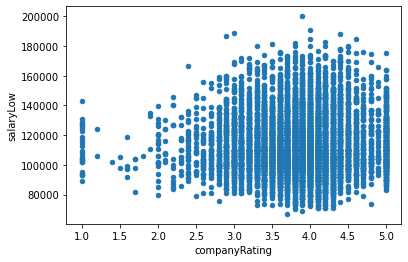

In [43]:
salaryDataframe.plot.scatter(x="companyRating", y="salaryLow")

In [44]:
salaryDataframe[["companyRating", "salaryLow"]].corr(method="pearson")

,companyRating,salaryLow
companyRating,1.000000,0.036288
salaryLow,0.036288,1.000000


<AxesSubplot:xlabel='companyRating', ylabel='salaryMid'>

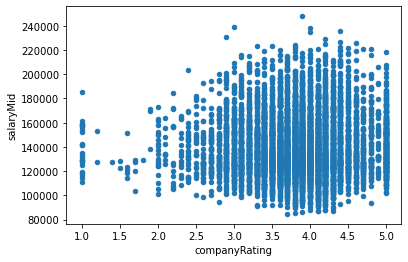

In [45]:
salaryDataframe.plot.scatter(x="companyRating", y="salaryMid")

In [46]:
salaryDataframe[["companyRating", "salaryMid"]].corr(method="pearson")

,companyRating,salaryMid
companyRating,1.000000,0.039133
salaryMid,0.039133,1.000000


<AxesSubplot:xlabel='companyRating', ylabel='salaryHigh'>

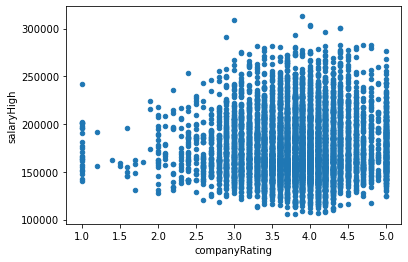

In [47]:
salaryDataframe.plot.scatter(x="companyRating", y="salaryHigh")

In [48]:
salaryDataframe[["companyRating", "salaryHigh"]].corr(method="pearson")

,companyRating,salaryHigh
companyRating,1.000000,0.041412
salaryHigh,0.041412,1.000000


There is no correlation between company rating and salary. Thus, a higher company rating does not mean that the salary will be higher.

Is there any correlation between the sample size and salary?

<AxesSubplot:xlabel='sampleSize', ylabel='salaryLow'>

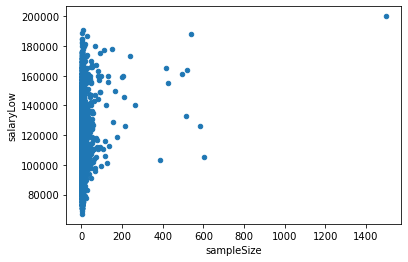

In [49]:
salaryDataframe.plot.scatter(x="sampleSize", y="salaryLow")

In [50]:
salaryDataframe[["sampleSize", "salaryLow"]].corr(method="pearson")

,sampleSize,salaryLow
sampleSize,1.000000,0.124792
salaryLow,0.124792,1.000000


<AxesSubplot:xlabel='sampleSize', ylabel='salaryMid'>

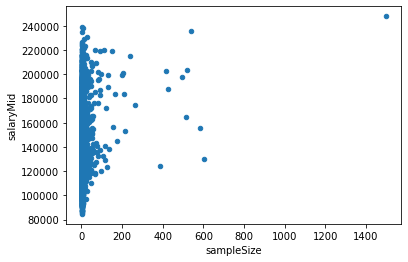

In [51]:
salaryDataframe.plot.scatter(x="sampleSize", y="salaryMid")

In [52]:
salaryDataframe[["sampleSize", "salaryMid"]].corr(method="pearson")

,sampleSize,salaryMid
sampleSize,1.000000,0.121043
salaryMid,0.121043,1.000000


<AxesSubplot:xlabel='sampleSize', ylabel='salaryHigh'>

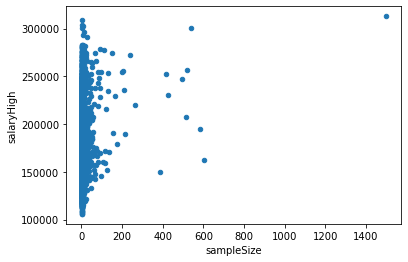

In [53]:
salaryDataframe.plot.scatter(x="sampleSize", y="salaryHigh")

In [54]:
salaryDataframe[["sampleSize", "salaryHigh"]].corr(method="pearson")

,sampleSize,salaryHigh
sampleSize,1.000000,0.116718
salaryHigh,0.116718,1.000000


There is also no correlation between sample size and salary. A larger sample size is an indication that the company is larger in size. Thus, a larger company size does not mean that the salary will be higher.

What is the total sample size in the dataset?

In [55]:
sum(salaryDataframe.sampleSize)

32643

What are the averages of the salary lows, mids, and highs?

In [56]:
# average of salary low
salaryDataframe.salaryLow.mean()

113782.72751677853

In [57]:
# average of salary mid
salaryDataframe.salaryMid.mean()

140558.92738255035

In [58]:
# average of salary high
salaryDataframe.salaryHigh.mean()

175731.25369127517

<u> resources </u>  
https://www.youtube.com/watch?v=Xjv1sY630Uc  
https://stackoverflow.com/questions/64717302/deprecationwarning-executable-path-has-been-deprecated-selenium-python  
https://pythonbasics.org/selenium-get-html/  
https://stackabuse.com/guide-to-parsing-html-with-beautifulsoup-in-python/